# Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/home_detection/code


In [2]:
%%time
from mobilkit.umni import *
from setup import P, Region, Dataset

CPU times: user 4.85 s, sys: 3.71 s, total: 8.56 s
Wall time: 4.13 s


In [3]:
import shutil

In [4]:
SP.start()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/10 17:22:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/10 17:22:38 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/05/10 17:22:38 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/05/10 17:22:38 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


# Load data

In [5]:
algos = ['A0', 'A1', 'A2', 'A3', 'A4']
algo_colors = sns.color_palette('Set1', len(algos))

## Datasets and regions

In [6]:
regions = [Region.load(k) for k in P.params.get('regions').keys()]
br = regions[1]; br

Region(Baton Rouge)

In [7]:
datasets = [Dataset.load(k, [r for r in regions if r.key == v['region']][0])
            for k, v in P.params.get('datasets').items()]
ds2 = datasets[1]; ds2

Dataset D2(Baton Rouge: 2021-08-26 - 2021-09-07)

In [8]:
regions = list({ds.region for ds in datasets})

## Common users across all algos

In [9]:
def get_common_users(rgn, algos=algos):
    return Seq(list(reduce(set.intersection, [
        set(pd.read_parquet(ds.data / f'homes/{alg}.parquet')[UID])
        for alg in algos])), name=UID)

In [10]:
for ds in tqdm(datasets):
    ds.common_users = get_common_users(ds)

  0%|          | 0/8 [00:00<?, ?it/s]

## Dataset summary

In [11]:
def table_dataset_summary(datasets=datasets):
    res = []
    for ds in tqdm(datasets):
        acs = gpd.read_file(ds.region.data / 'acs.gpkg')
        users = ds.common_users.reset_index()
        pct_popu = round(len(users) / acs['popu'].sum(), 3)
        df = SP.read_parquet(ds.data / 'counts.parquet')
        df = df.join(SP.pdf2sdf(users), on=UID)
        nPings = df.agg(F.sum('n_pings')).collect()[0][0]
        period = ds.start.strftime('%b %-d') + ' – ' + ds.end.strftime('%b %-d, %Y')
        res.append(dict(name=ds.key, region=ds.region.name,
                        period=period, nDays=len(ds.dates),
                        n_users=len(users) / 1000, pct_popu=pct_popu, 
                        n_pings=nPings / 1e6))
    return Pdf(res)

# %time table_dataset_summary() # t=1:28

# M1: Land use performance metric

## Load the buffers
Clip them within the city limit for comparison

In [12]:
def get_resi_buffers_clipped(rgn, max_buffer=200):
    paths = [f for f in (rgn.data / 'landuse/buffers_within_city_limit')
             .glob('*.parquet') if int(f.stem) <= max_buffer]
    return pd.concat([gpd.read_parquet(f) for f in paths])

# get_resi_buffers_clipped(br)

In [13]:
# t=0:07
pbar = tqdm(regions)
for rgn in pbar:
    pbar.set_description(str(rgn))
    rgn.resi = get_resi_buffers_clipped(rgn)

  0%|          | 0/4 [00:00<?, ?it/s]

## Compute performance

In [33]:
def get_resi_detection_rate(ds, alg, users=None, filt_commons=True,
                            save=True, overwrite=False, pbar=False, time=True):
    outfile = ds.data / f'metrics/{alg}/M1.parquet'
    if outfile.exists() and not overwrite:
        return pd.read_parquet(outfile)
    start_time = dt.datetime.now()
    boundary = gpd.read_file(ds.region.data / 'city_limit.gpkg')
    homes = pd.read_parquet(ds.data / f'homes/{alg}.parquet')
    if filt_commons:
        homes = homes.merge(ds.common_users, on=UID)
    if isinstance(users, Pdf):
        homes = homes.merge(users, on=UID)
    homes = mk.geo.pdf2gdf(homes, crs=CRS_DEG)
    homes = (homes.sjoin(boundary, predicate='within')
             .set_index(UID)[['geometry']])
    resi = ds.region.resi.set_index('buffer').sort_index()
    df = Pdf(0, columns=resi.index, index=homes.index)
    rows = zip(resi.index, resi.geometry)
    if pbar: rows = tqdm(list(rows))
    for buf, geom in rows:
        geom = Gdf({'geometry': [geom]}, crs=CRS_DEG)
        within = homes.sjoin(geom, predicate='within')
        df.loc[within.index, buf:] = 1
        homes = homes.loc[list(set(homes.index) - set(within.index))]
    df = df.astype(np.int8)
    df.columns = df.columns.astype(str)
    if save:
        df.to_parquet(U.mkfile(outfile))
    if time:
        print(f'Runtime for {ds} for {alg}: {dt.datetime.now() - start_time}')
    return df
    
# %time x = get_resi_detection_rate(ds2, 'A1', overwrite=1, save=0); x

In [35]:
%%time
# t=3:39 ({1=>0:09, 2=>0:06, 3=>0:16, 4=>0:36, 5=>0:28, 6=>0:47, 7=>0:18, 8=>0:59})
for ds in tqdm(datasets):
    for alg in algos:
        df = get_resi_detection_rate(ds, alg, overwrite=False)

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 548 ms, sys: 118 ms, total: 666 ms
Wall time: 371 ms


## Visualize

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 14.5 s, sys: 6.61 s, total: 21.1 s
Wall time: 13.4 s


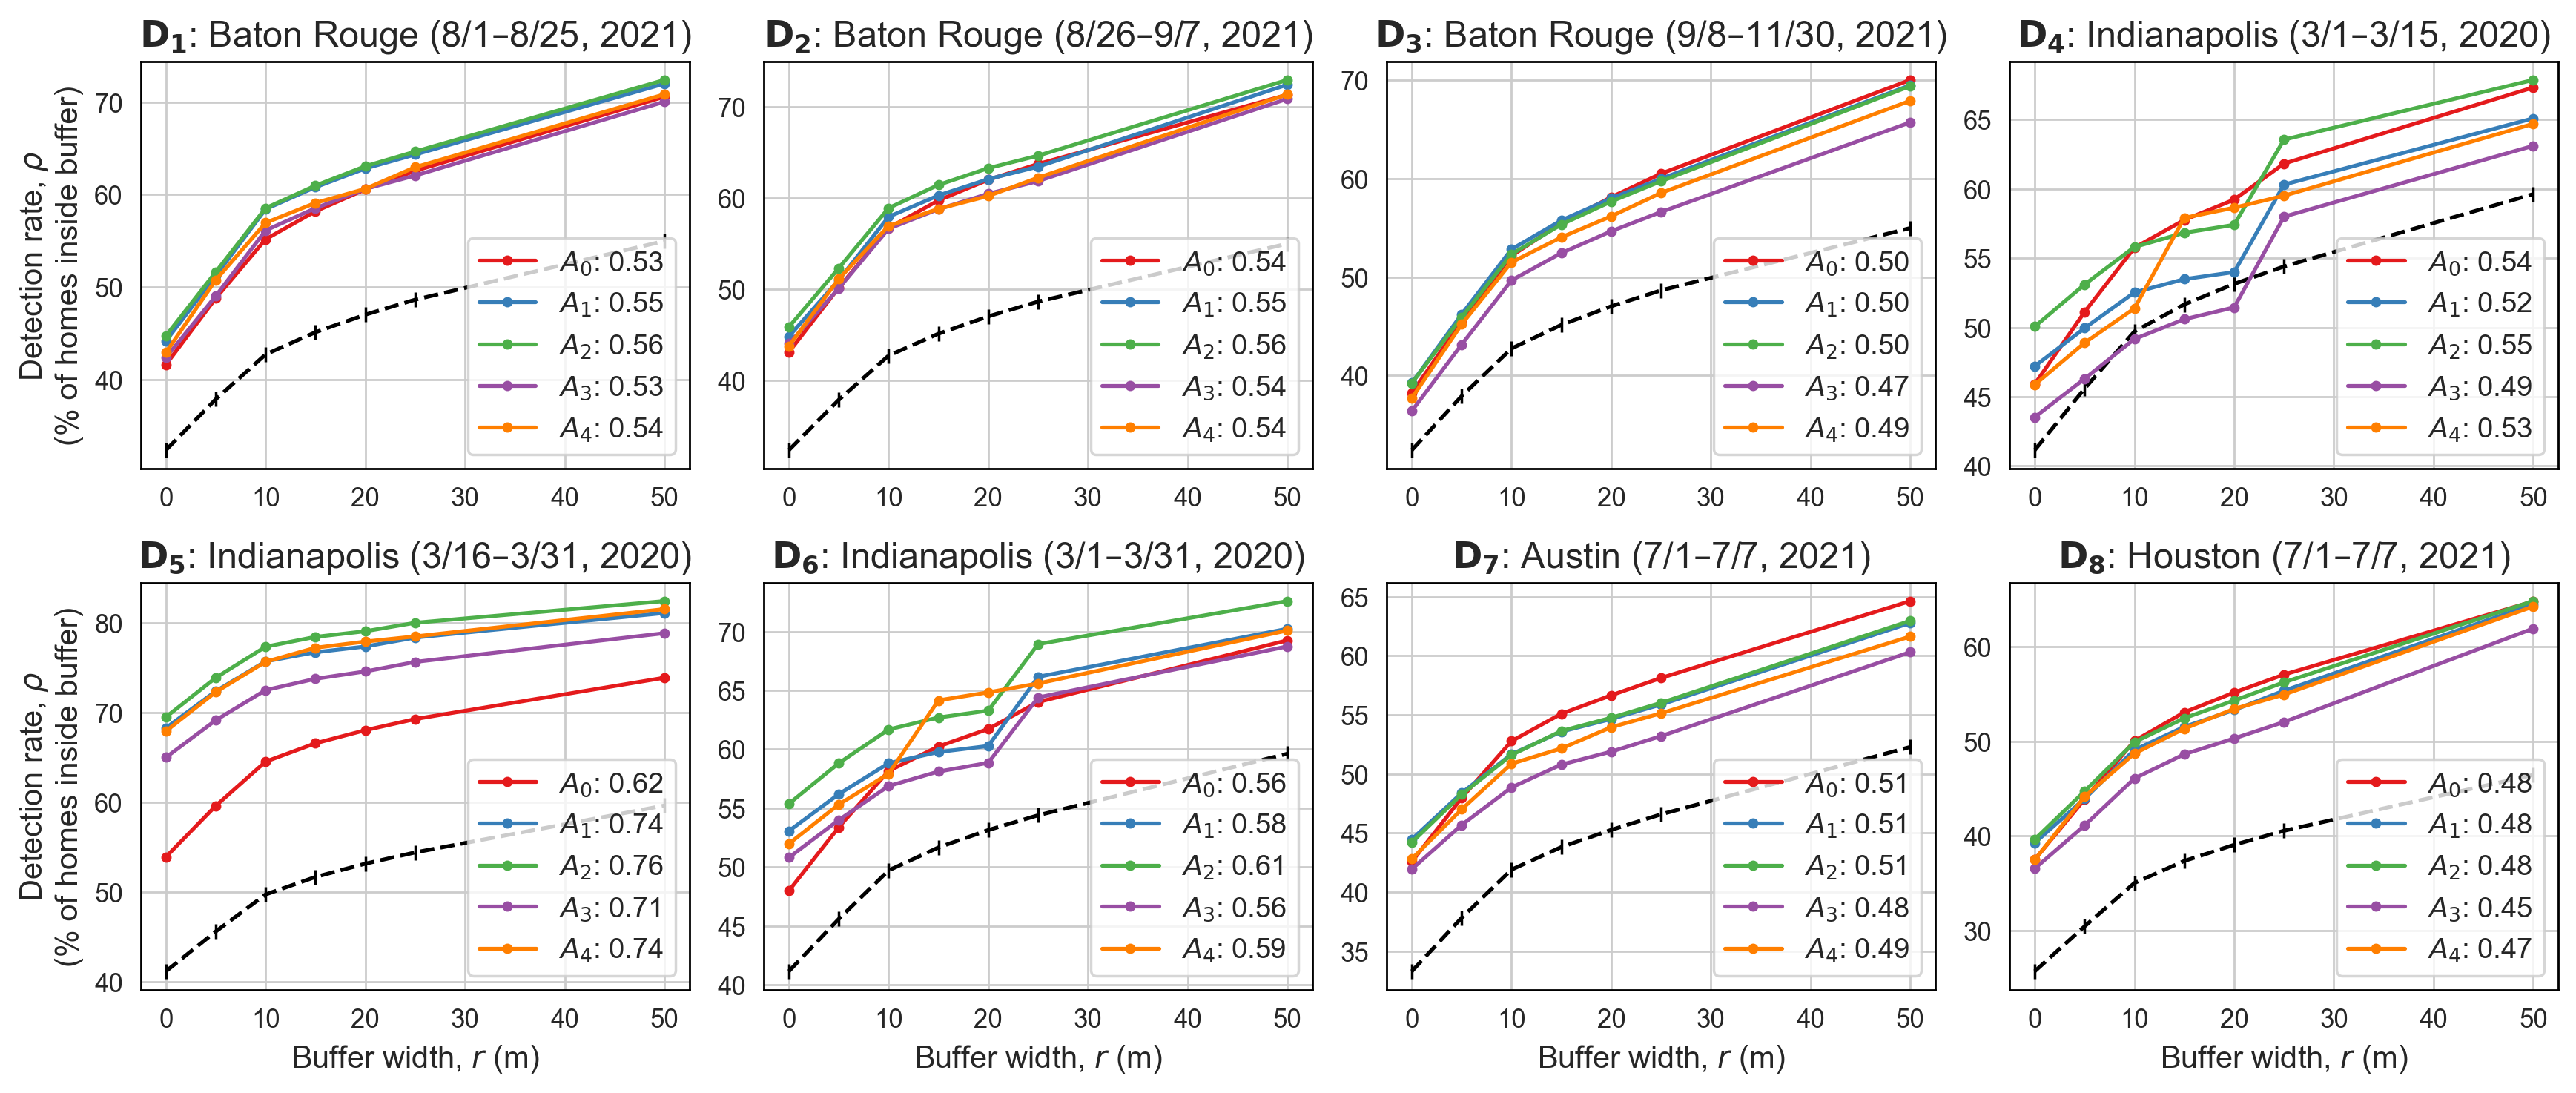

In [16]:
def fig_m1(datasets=datasets, algos=algos, max_buf=np.inf, colors=algo_colors, 
           ncol=4, size=(3.5, 3), dpi=120):
    nrow = int(np.ceil(len(datasets) / ncol))
    figsize = (ncol * size[0], nrow * size[1])
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, dpi=dpi, sharey=False)
    for i, (ax, ds) in enumerate(tqdm(list(zip(axes.flatten(), datasets)))):
        city_lim = gpd.read_file(ds.region.data / 'city_limit.gpkg')
        tot_area = city_lim.to_crs(CRS_M).area.sum()
        resi = (ds.region.resi.query(f'buffer <= {max_buf}')
                .set_index('buffer').sort_index().to_crs(CRS_M))
        resi['pct_area'] = resi.area / tot_area * 100
        ax = U.plot(ax, framebordercolor='k')
        ax.plot(resi.index, resi['pct_area'], marker='|', color='k', ls='--', lw=1.5)
        for alg, color in zip(algos, algo_colors):
            df = pd.read_parquet(ds.data / f'metrics/{alg}/M1.parquet')
            df = df[df['buffer'] <= max_buf].sort_values('buffer')
            x, y = df['buffer'].values, df['det_rate'].values
            m1 = (y * (x.max() - x)).sum() / (x.max() - x).sum() / 100
            label = '$%s$: %0.2f' % (f'{alg[0]}_{alg[1]}', m1)
            ax.plot(x, y, marker='.', color=color, label=label, lw=1.5)
        title = '$\mathbf{%s}$: %s (%s–%s)' % (
            f'{ds.key[0]}_{ds.key[1]}', ds.region.name, 
            ds.start.strftime('%-m/%-d'), ds.end.strftime('%-m/%-d, %Y'))
        xlab = r'Buffer width, $r$ (m)' if i // ncol == nrow - 1 else ''
        ylab = (r'Detection rate, $\rho$'+'\n(% of homes inside buffer)'
                if i % ncol == 0 else '')
        ax = U.plot(ax, title=title, xlab=xlab, ylab=ylab)
        ax.legend(loc='lower right')
    plt.tight_layout()
    
%time x = fig_m1(dpi=250, max_buf=50); x # t=0:18

# M2: Trajectory proximity

## Compute daily min distances

In [17]:
def dist_deg2m(dist, lat, a=6_371_001, b=6_356_752):
    """
    Convert given distance in degrees to meters.
    See `mobilkit.geo.dist_m2deg` for more details.
    """
    lat = np.deg2rad(lat)
    curve_radius = (a * b) ** 2 / (
            (a * np.cos(lat)) ** 2 + (b * np.sin(lat)) ** 2) ** 1.5
    return float(np.deg2rad(dist) * curve_radius)

In [18]:
def get_traj_proximity(ds, alg, save=True, overwrite=False):
    outfile = ds.data / f'metrics/{alg}/M2.parquet'
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    start_time = dt.datetime.now()
    homes = (pd.read_parquet(ds.data / f'homes/{alg}.parquet')
             .merge(ds.common_users, on=UID)
             .rename(columns={LON: 'homeX', LAT: 'homeY'}))
    df = SP.read_parquet(ds.data / f'night_pings')
    df = df.select(UID, F.arrays_zip(LON, LAT, TS).alias('pts'))
    df = df.select(UID, F.explode('pts').alias('pt'))
    df = df.select(UID, *[F.col('pt')[x].alias(x) for x in [LON, LAT, TS]])
    df = df.withColumn('day', F.floor(F.col(TS) / 86400).cast(T.int16))
    df = df.groupby(UID, 'day').agg(*[
        F.collect_list(x).alias(x) for x in [LON, LAT]])
    df = df.join(SP.pdf2sdf(homes), on=UID)
    df = df.withColumn('n_pings', F.size(LON).cast(T.int16))
    def dist4home(x, y, homex, homey):
        d = np.min(((Arr(x) - homex)**2 + (Arr(y) - homey)**2)**0.5)
        return dist_deg2m(d, homey)
    df = df.withColumn('dist', F.udf(dist4home, T.float)
                       (LON, LAT, 'homeX', 'homeY'))
    df = df.select(UID, 'day', 'n_pings', 'dist')
    if save:
        df.toPandas().to_parquet(U.mkfile(outfile))
    return df
    
# %time x = get_traj_proximity(ds2, 'A1', save=0, overwrite=1); x

In [19]:
%%time
# t=11:03 ({1=>1:01, 2=>0:20, 3=>???, 4=>???, 5=>???, 6=>???, 7=>???, 8=>???})
for ds in tqdm(datasets):
    for alg in algos:
        df = get_traj_proximity(ds, alg, overwrite=False)

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 90.1 ms, sys: 32.2 ms, total: 122 ms
Wall time: 9.89 s


## Visualize

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 15.1 s, sys: 4.91 s, total: 20 s
Wall time: 13.5 s


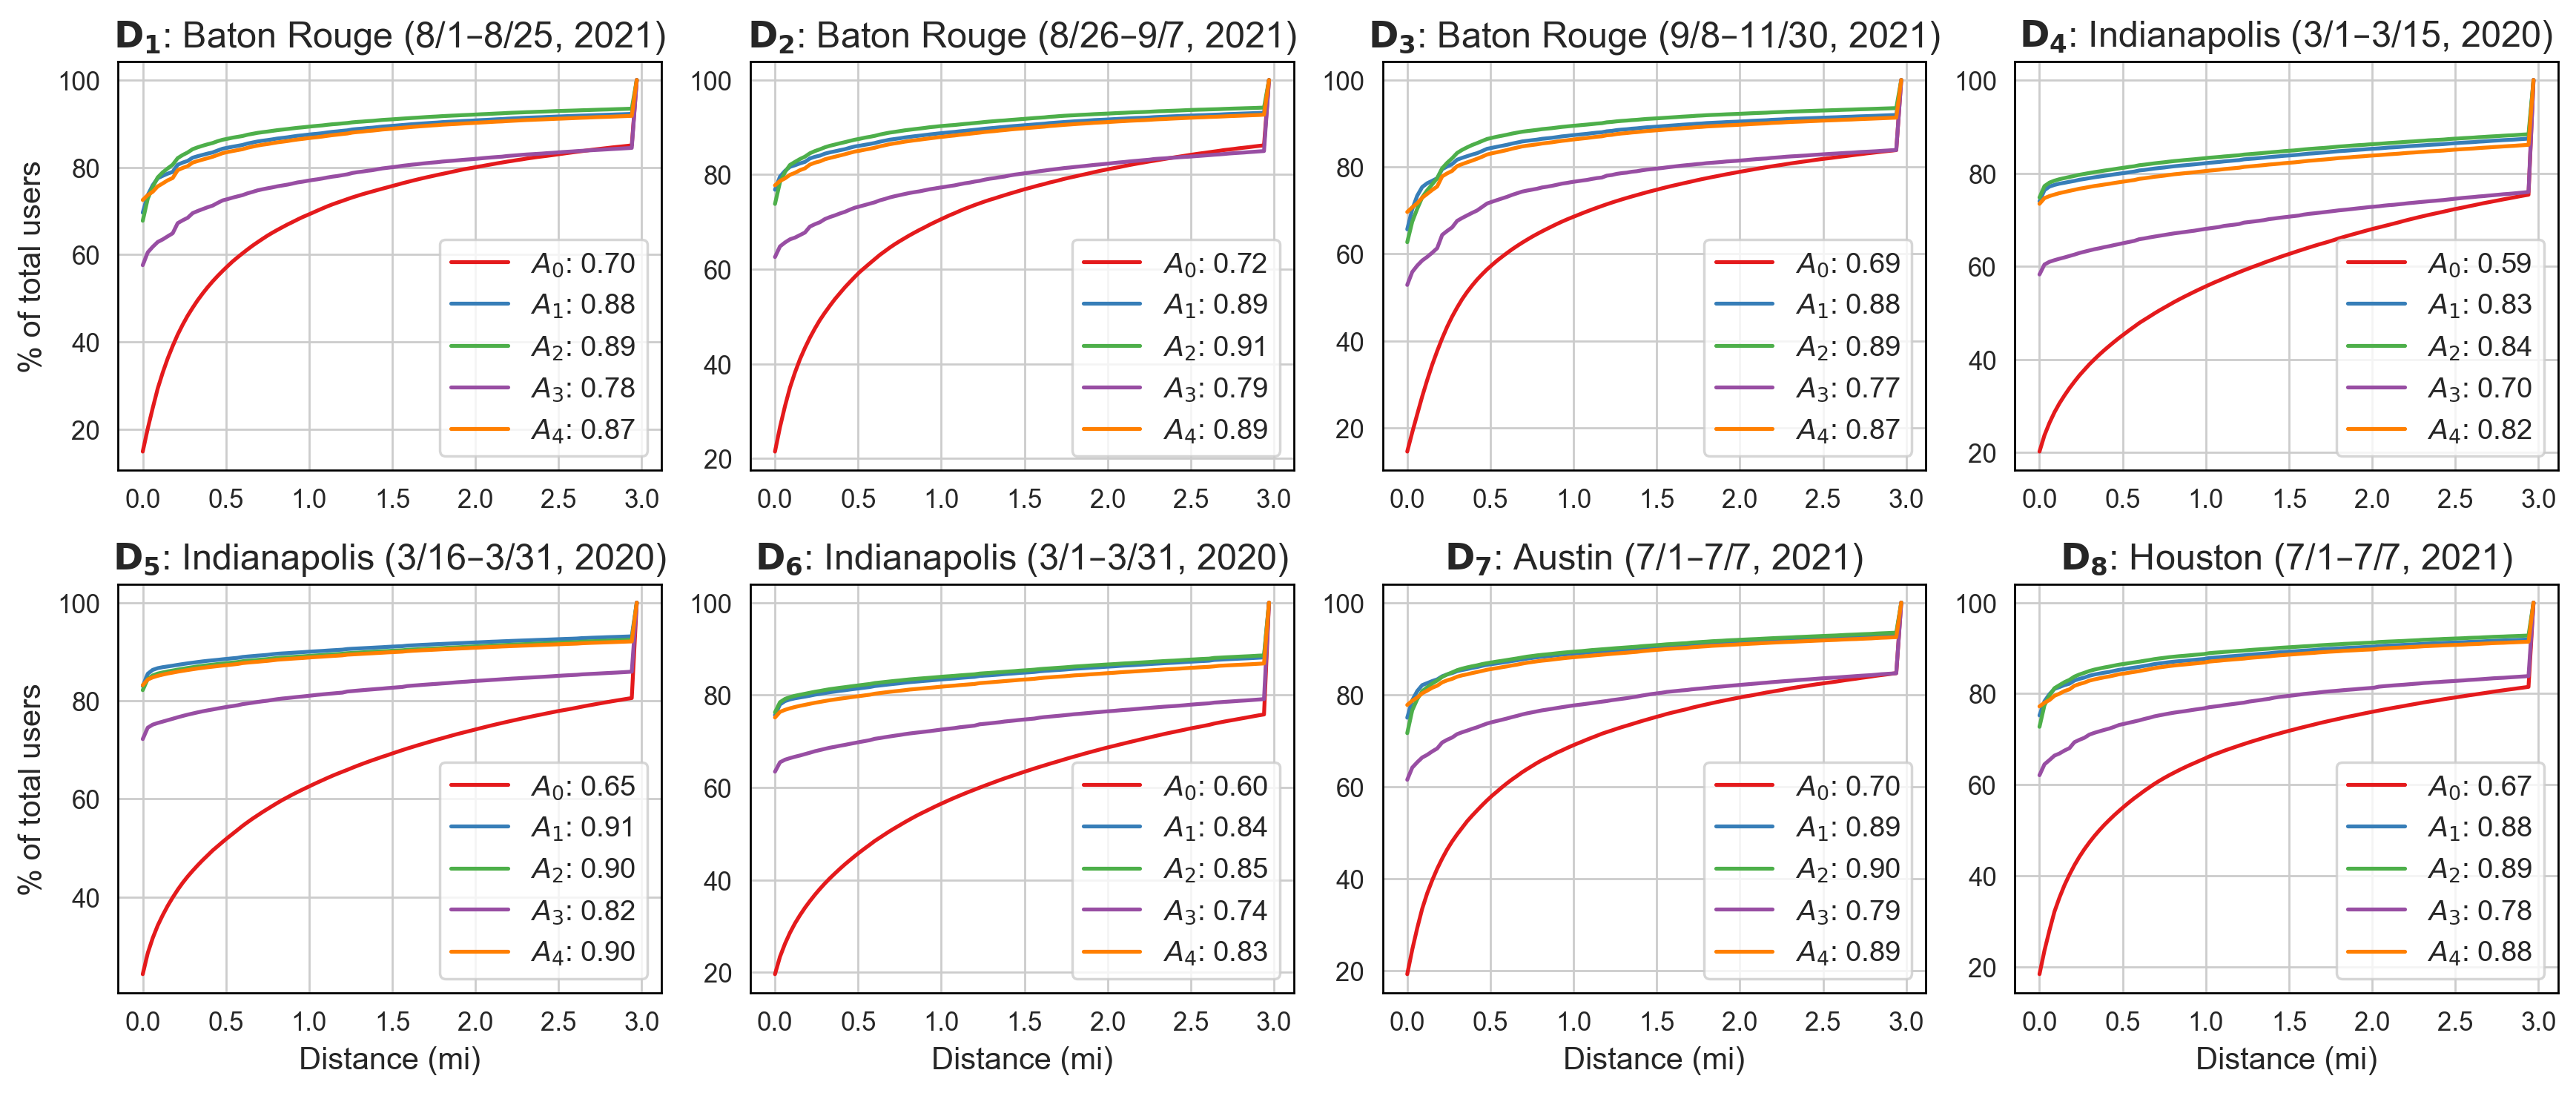

In [20]:
def fig_m2(datasets=datasets, algos=algos, colors=algo_colors, ylog=False,
           ncol=4, vmax=3, bins=100, cum=True, panel_size=(3.5, 3), dpi=120):
    nrow = int(np.ceil(len(datasets) / ncol))
    figsize = (ncol * panel_size[0], nrow * panel_size[1])
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, dpi=dpi, sharey=False)
    for i, (ax, ds) in enumerate(tqdm(list(zip(axes.flatten(), datasets)))):
        ax = U.plot(ax, framebordercolor='k')
        for alg, color in zip(algos, colors):
            df = pd.read_parquet(ds.data / f'metrics/{alg}/M2.parquet')
            for j, (agg_fn, ls) in enumerate([(np.median, '-')]):
                df2 = df.groupby(UID)['dist'].agg(agg_fn)
                y, x = np.histogram((df2.values * U.M2MI).clip(0, vmax), bins=bins)
                y = (y.cumsum() if cum else y) / y.sum() * 100
                m2 = y.sum() / (100 * len(y))
                label = '$%s$: %0.2f' % (f'{alg[0]}_{alg[1]}', m2)
                ax.plot(x[:-1], y, color=color, ls=ls,
                        label=label if j == 0 else None)
        title = '$\mathbf{%s}$: %s (%s–%s)' % (
            f'{ds.key[0]}_{ds.key[1]}', ds.region.name, 
            ds.start.strftime('%-m/%-d'), ds.end.strftime('%-m/%-d, %Y'))
        xlab = 'Distance (mi)' if i // ncol == nrow - 1 else ''
        ylab = '% of total users' if i % ncol == 0 else ''
        ax = U.plot(ax, title=title, xlab=xlab, ylab=ylab, ylog=ylog)
        ax.legend()
    plt.tight_layout()

%time x = fig_m2(dpi=250); x # t=0:13

# M3: Home stay duration

## Load data
Prepared by Shagun and stored in [/home/umni2/a/umnilab/users/mittal53/home inference/data files/final_results](/home/umni2/a/umnilab/users/mittal53/home%20inference/data%20files/final_results).

In [21]:
def copy_m3(datasets=datasets):
    inpath = Path('/home/umni2/a/umnilab/users/mittal53/home inference/data files/final_results')
    for f in inpath.glob('*.parquet'):
        ds_name, alg = f.stem[:2], f.stem[3:5]
        ds = [ds for ds in datasets if ds.key == ds_name][0]
        shutil.copy(f, ds.data / f'metrics/{alg}/M3.parquet')

# %time copy_m3()

## Visualize

  0%|          | 0/8 [00:00<?, ?it/s]

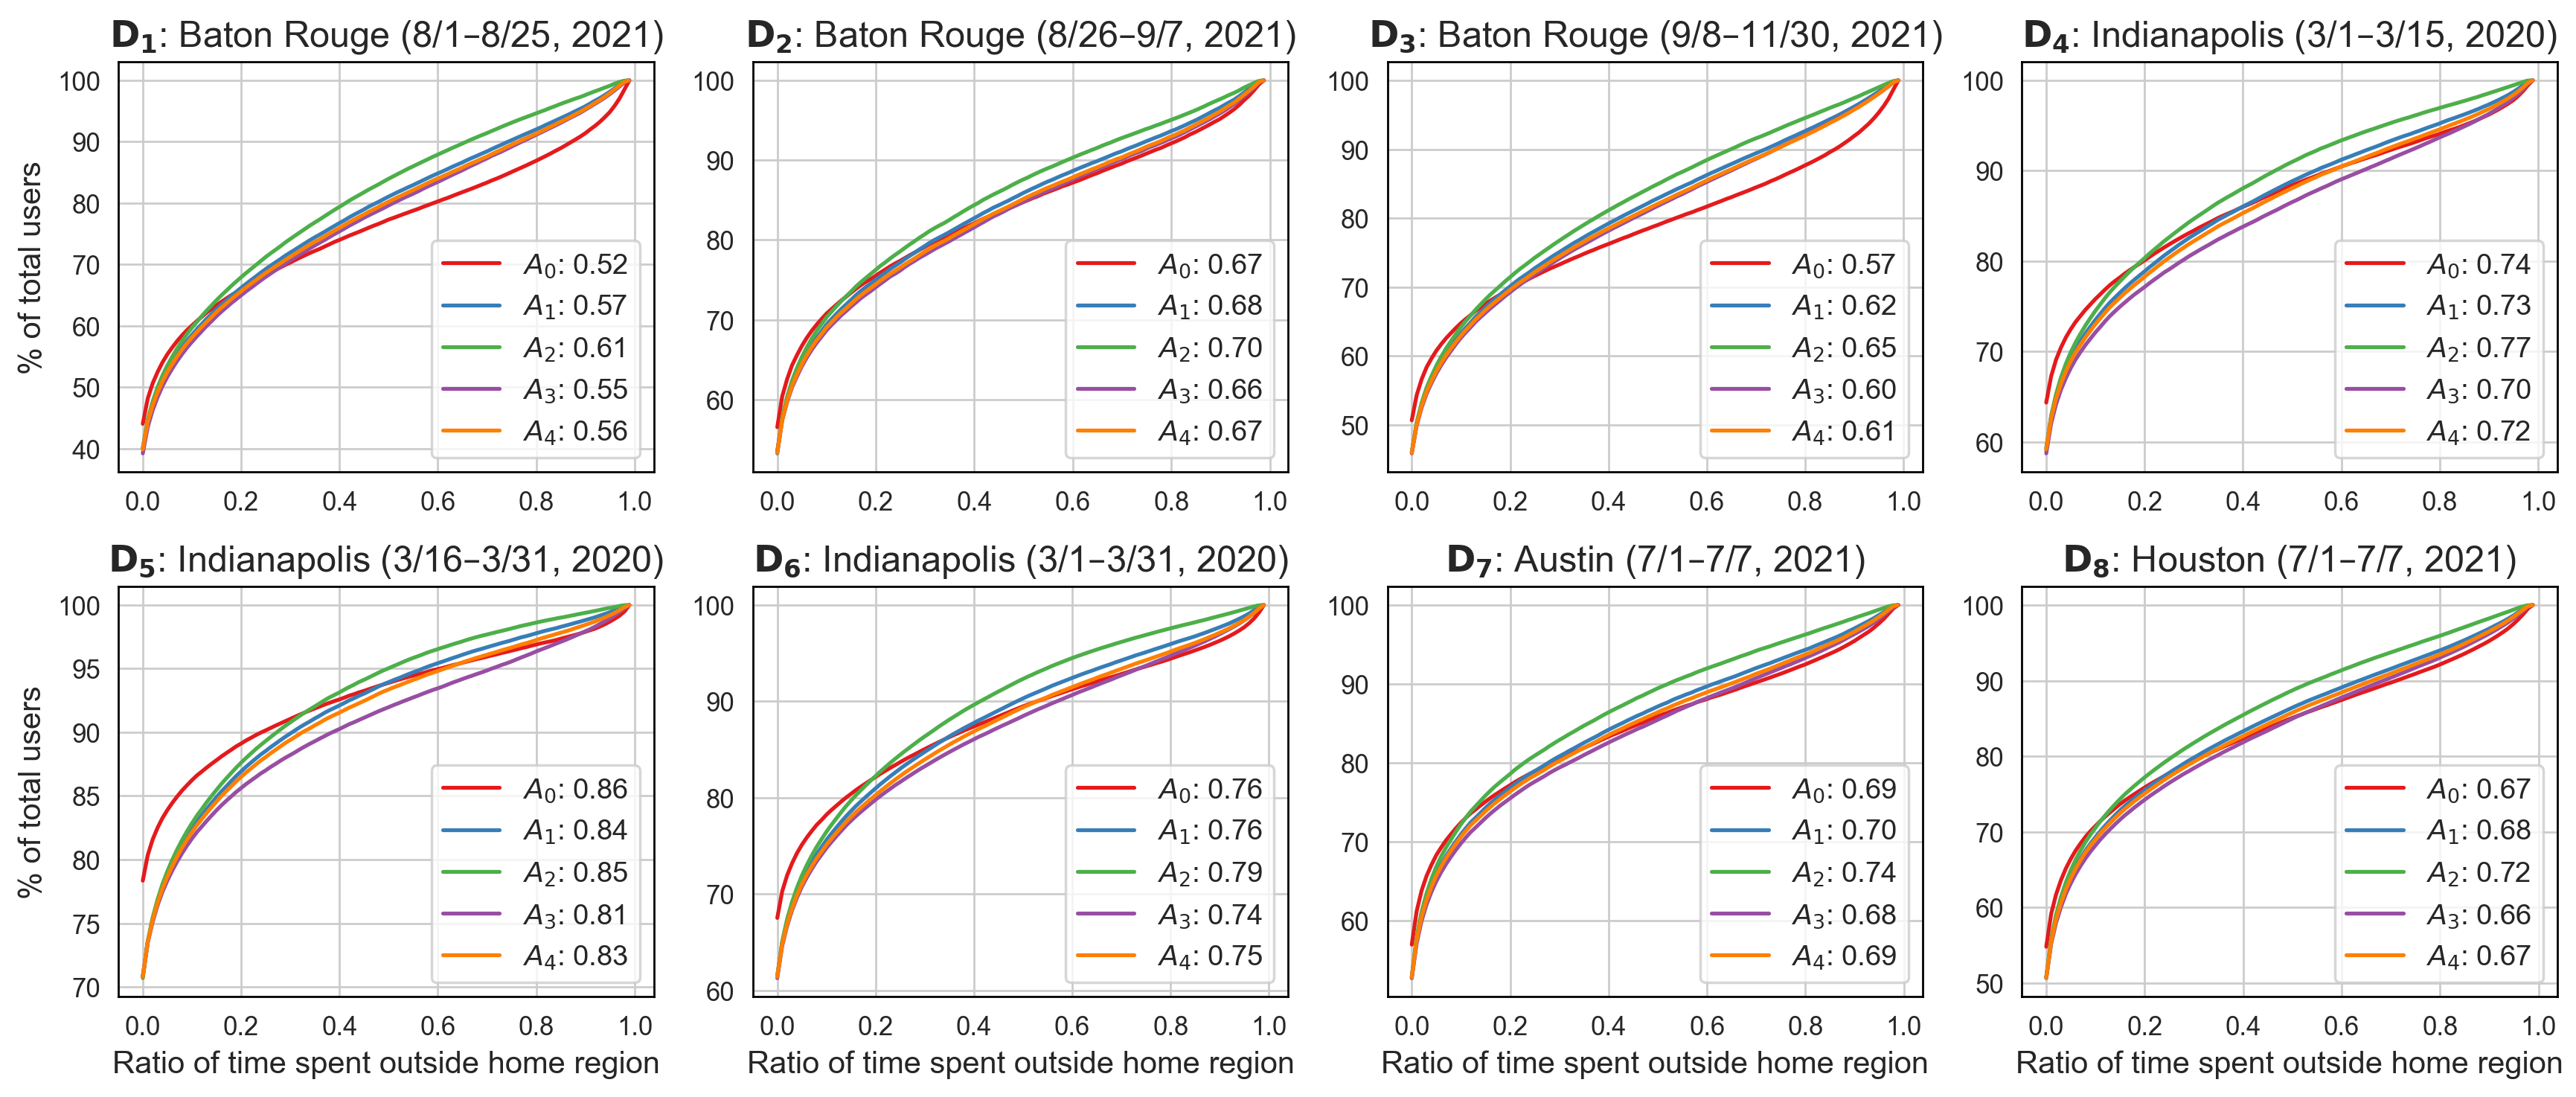

In [22]:
def fig_m3(datasets=datasets, algos=algos, colors=algo_colors, ylog=False,
           ncol=4, bins=100, panel_size=(3.5, 3), dpi=120):
    nrow = int(np.ceil(len(datasets) / ncol))
    figsize = (ncol * panel_size[0], nrow * panel_size[1])
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, dpi=dpi, sharey=False)
    for i, (ax, ds) in enumerate(tqdm(list(zip(axes.flatten(), datasets)))):
        ax = U.plot(ax, framebordercolor='k')
        for alg, color in zip(algos, algo_colors):
            df = pd.read_parquet(ds.data / f'metrics/{alg}/M3.parquet')
            df = df.merge(ds.common_users, on=UID)
            df['home_stay_ratio'] = 1 - df['home_time_spent'] / df['total_time_spent']
            y, x = np.histogram(df['home_stay_ratio'], bins=bins); x = x[:-1]
            y = y.cumsum() / y.sum()
            # y = y - x
            m3 = 2 * y.mean() - 1
            label = '$%s$: %0.2f' % (f'{alg[0]}_{alg[1]}', m3)
            ax.plot(x, y * 100, color=color, label=label)
            # ax.plot([0, 1], [0, 100], ls='--', color='k', lw=1)
        title = '$\mathbf{%s}$: %s (%s–%s)' % (
            f'{ds.key[0]}_{ds.key[1]}', ds.region.name, 
            ds.start.strftime('%-m/%-d'), ds.end.strftime('%-m/%-d, %Y'))
        xlab = 'Ratio of time spent outside home region' if i // ncol == nrow - 1 else ''
        ylab = '% of total users' if i % ncol == 0 else ''
        ax = U.plot(ax, title=title, xlab=xlab, ylab=ylab, ylog=ylog)
        ax.legend()
        # return ax
    plt.tight_layout()

x = fig_m3(dpi=250); x

# Sensitivity analysis

## User quality

In [23]:
day_hrs = P.params.get('filters.base_day_hours')
slot_size = P.params.get('filters.slot_size')
day_hrs, slot_size

([7, 19], 1800)

In [38]:
def get_user_ping_count(ds, tot_pings=True, day_hrs=day_hrs, slot_size=slot_size):
    night_end, night_start = [x * 3600 / slot_size for x in day_hrs]
    df = SP.read_parquet(ds.data / 'counts.parquet')
    df = df.where((df.slot >= night_start) | (df.slot <= night_end))
    if tot_pings:
        df = df.groupby(UID).agg(F.sum('n_pings').alias('n_pings'))
        df = df.sort(F.col('n_pings').desc())
    else:
        df = df.groupby(UID).count().withColumnRenamed('count', 'n_slots')
        df = df.sort(F.col('n_slots').desc())
    return df.toPandas()

# get_user_ping_count(ds2)

In [25]:
%time for ds in tqdm(datasets): ds.counts = get_user_ping_count(ds) # t=0:28

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 248 ms, sys: 189 ms, total: 437 ms
Wall time: 28.6 s


In [39]:
%time for ds in tqdm(datasets): ds.n_slots = get_user_ping_count(ds, tot_pings=False) # t=0:28

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 229 ms, sys: 200 ms, total: 430 ms
Wall time: 23 s


## User-ping count Lorenz curves

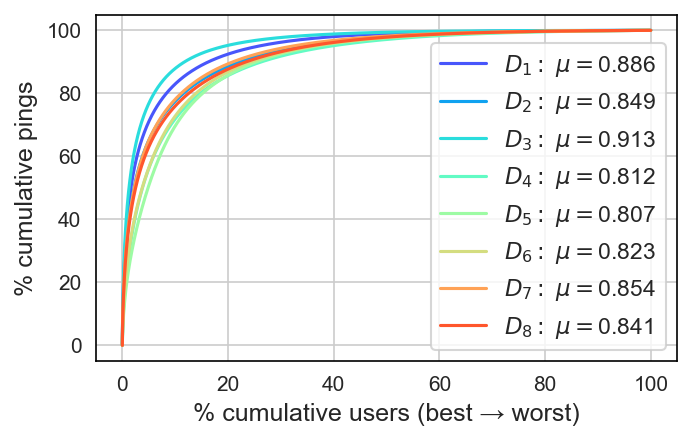

In [26]:
def get_ping_count_lorenz_curve(datasets=datasets, bins=np.arange(101), 
                                cmap='rainbow', size=(5, 3), dpi=120):
    ax = U.plot(size=size, dpi=dpi, framebordercolor='k',
                xlab='% cumulative users (best → worst)',
                ylab='% cumulative pings')
    colors = sns.color_palette(cmap, len(datasets))
    for ds, color in zip(datasets, colors):
        y = ds.counts['n_pings'].reset_index(drop=True)
        nUsers, nPings = len(y), sum(y)
        y = y.cumsum() / y.sum()
        gini = 2 * (y.sum() / len(y)) - 1
        label = '$%s_%s:\;\mu=$%.3f' % (ds.key[0], ds.key[1], gini)
        ax.plot(y.index / len(y) * 100, y * 100, color=color, label=label)
    ax.legend(loc='lower right')
    
get_ping_count_lorenz_curve(dpi=150)

In [27]:
def plot_quantile_ping_count(ds, ax=None, yticks=True, bins=10, color='c', alpha=0.2):
    users = ds.counts.merge(ds.common_users, on=UID)
    users.index = 100 * users.index / len(users)
    bins = np.linspace(0, 100, bins+1)
    users['bin'] = pd.cut(users.index, bins, include_lowest=True)
    nPings = users.groupby('bin')['n_pings'].sum()
    nPings *= (100 / users['n_pings'].sum())
    nPings.index = bins[1:]
    ax = ax or U.plot(size=(5, 3), dpi=120)
    nPings.plot(ax=ax, color=color, marker='.', 
                markersize=2, lw=1, alpha=alpha)
    nPings.plot(ax=ax, kind='area', color=color, alpha=alpha)
    ax.set_xticklabels([])
    if yticks: ax.set_ylabel('Percent pings')
    ax.grid(False)
    if not yticks:
        ax.set_yticklabels([])
    
# plot_quantile_ping_count(ds, None, yticks=False)

## M1 curves

In [28]:
def get_m1_sensitivity(datasets=datasets, algos=algos, bins=10, max_buffer=100, 
                       save=True, overwrite=False):
    pbar = tqdm(total=len(datasets) * len(algos) * bins)
    for i, ds in enumerate(datasets):
        idx = np.linspace(0, len(ds.counts), bins+1).astype(int)
        boundary = gpd.read_file(ds.region.data / 'city_limit.gpkg')
        resi = (ds.region.resi.query(f'buffer <= {max_buffer}')
                .set_index('buffer').sort_index())
        for j, alg in enumerate(algos):
            res = []
            pbar.set_description(f'{ds.key} -> {alg}')
            outfile = ds.data / f'sensitivity/{alg}/M1.parquet'
            if outfile.exists() and not overwrite:
                continue
            all_homes = (pd.read_parquet(ds.data / f'homes/{alg}.parquet')
                         .merge(ds.common_users, on=UID))
            all_homes = (mk.geo.pdf2gdf(all_homes, crs=CRS_DEG)
                         .sjoin(boundary, predicate='within')
                         .set_index(UID)[['geometry']])
            for k in range(bins):
                pbar.update()
                xval = (k+1) * 100 / bins
                users = ds.counts.iloc[idx[k]: idx[k+1]]
                det_rate = {}
                homes = all_homes.merge(users, on=UID)
                nHomes = len(homes)
                if nHomes == 0:
                    continue
                for buf, geom in zip(resi.index, resi.geometry):
                    geom = Gdf({'geometry': [geom]}, crs=CRS_DEG)
                    within = homes.sjoin(geom, predicate='within')
                    det_rate[buf] = 100 * len(within) / nHomes
                x, y = [Arr(p) for p in zip(*det_rate.items())]
                yval = (y * (x.max() - x)).sum() / (x.max() - x).sum() / 100
                res.append(dict(binx=xval, m1=yval))
            res = Pdf(res).dropna()
            if save:
                res.to_parquet(U.mkfile(outfile))
    
%time x = get_m1_sensitivity(overwrite=False); x # t=9:56

  0%|          | 0/400 [00:00<?, ?it/s]

CPU times: user 137 ms, sys: 37.4 ms, total: 175 ms
Wall time: 359 ms


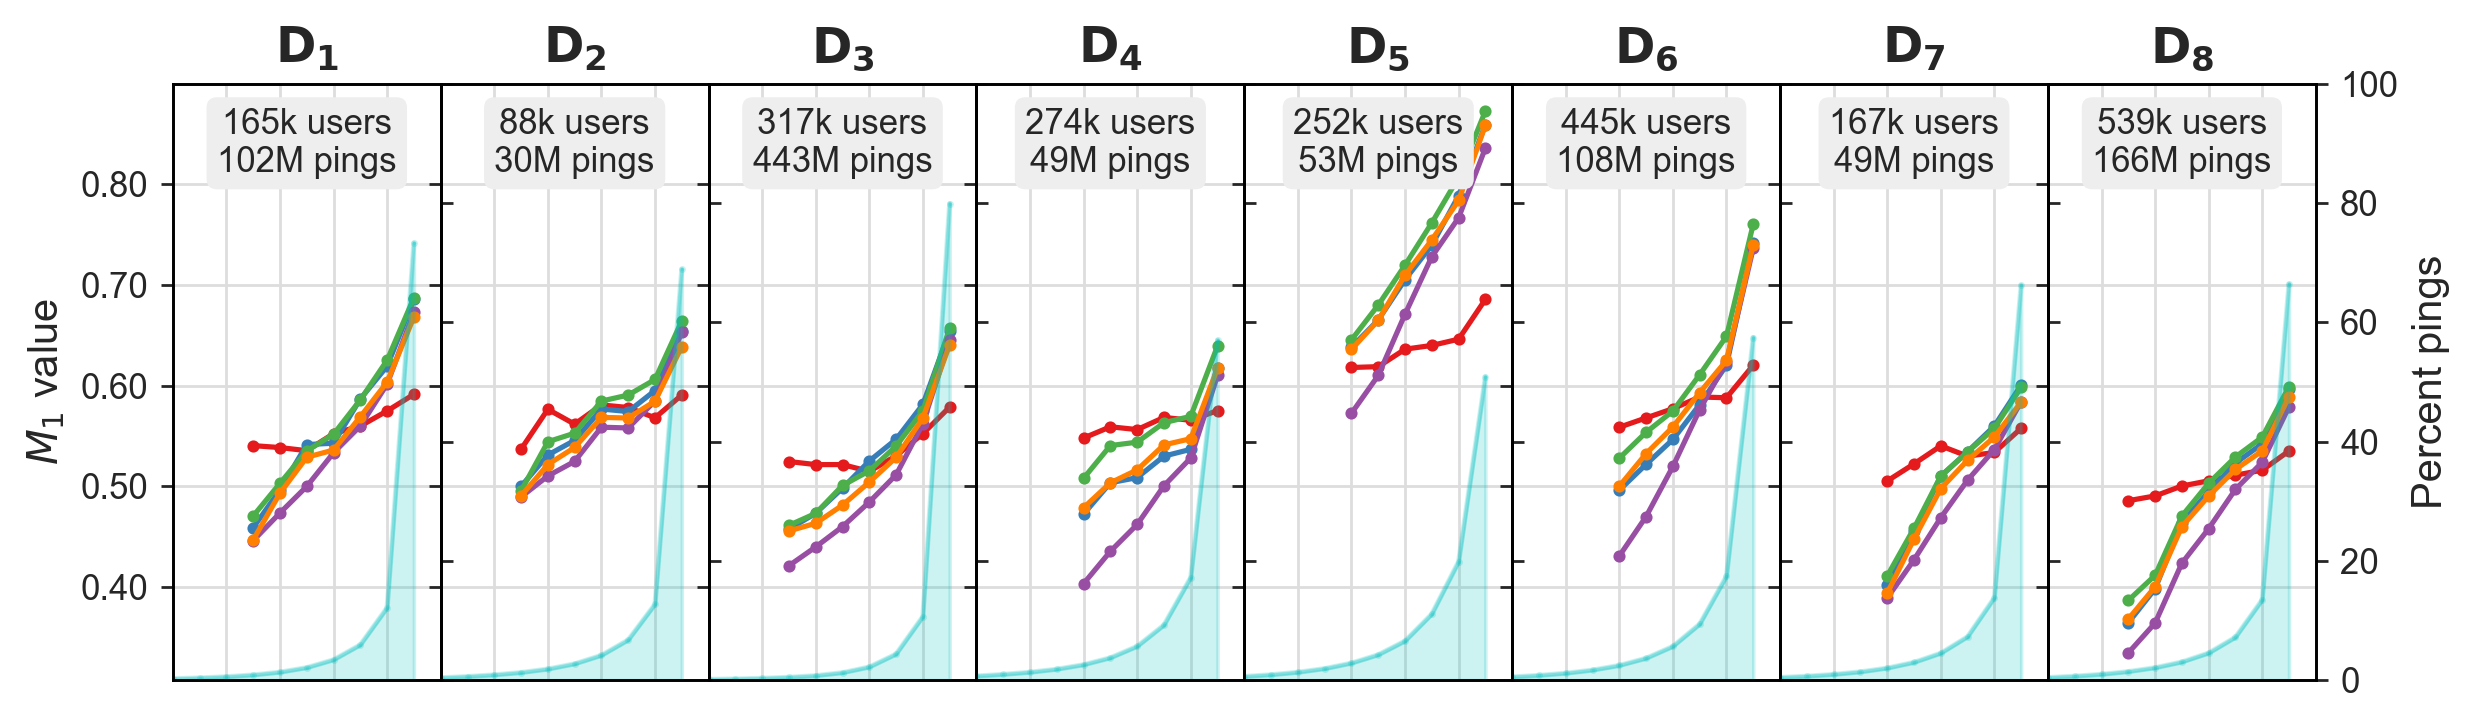

In [43]:
def plot_m1_sensitivity(datasets=datasets, algos=algos, colors=algo_colors,
                        use_nslots=False, n_bins=20, panel_size=(1.25, 3), dpi=120):
    # return datasets
    ncol = len(datasets)
    figsize = (ncol * panel_size[0], panel_size[1])
    fig, axes = plt.subplots(1, ncol, figsize=figsize, 
                             dpi=dpi, sharey=True, sharex=True)
    for i, ds in enumerate(datasets):
        ylab = r'$M_1$ value' if i == 0 else ''
        title = r'$\mathbf{%s_%s}$' % (ds.key[0], ds.key[1])
        ax = U.plot(axes[i], framebordercolor='#333', ylab=ylab, 
                    xlim=(0, 100), title=title, gridcolor='#ddd')
        for alg, color in zip(algos, algo_colors):
            df = pd.read_parquet(ds.data / f'sensitivity/{alg}/M1.parquet')
            label = '$%s_%s$' % (alg[0], alg[1])
            ax.plot(df['binx'], df['m1'], color=color, 
                    marker='.', markersize=5, lw=1.5)
        users = (ds.n_slots if use_nslots else ds.counts)
        users = users.merge(ds.common_users, on=UID)
        nUsers, nPings = len(users), users['n_pings'].sum()
        ax.text(0.5, 0.96, f'{nUsers/1e3:.0f}k users\n{nPings/1e6:.0f}M pings', 
                va='top', ha='center', transform=ax.transAxes, 
                bbox=dict(boxstyle='Round', pad=0.3, 
                          edgecolor='none', facecolor='#eee'))
        ax.invert_xaxis()
        ticks = np.arange(0, 100+1, 20)
        ax.set_xticks(ticks[:-1])
        ax.set_xticklabels([])
        formatter = mpl.ticker.StrMethodFormatter('{x:,.2f}')
        ax.yaxis.set_major_formatter(formatter)
        # if i == ncol - 1: ax.legend(loc=(1.1, .4), ncol=1)
        twin = U.plot(ax.twinx(), ylim=(0, 100), framebordercolor='k')
        plot_quantile_ping_count(ds, twin, yticks=i == ncol - 1)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0)
    
plot_m1_sensitivity(dpi=250)

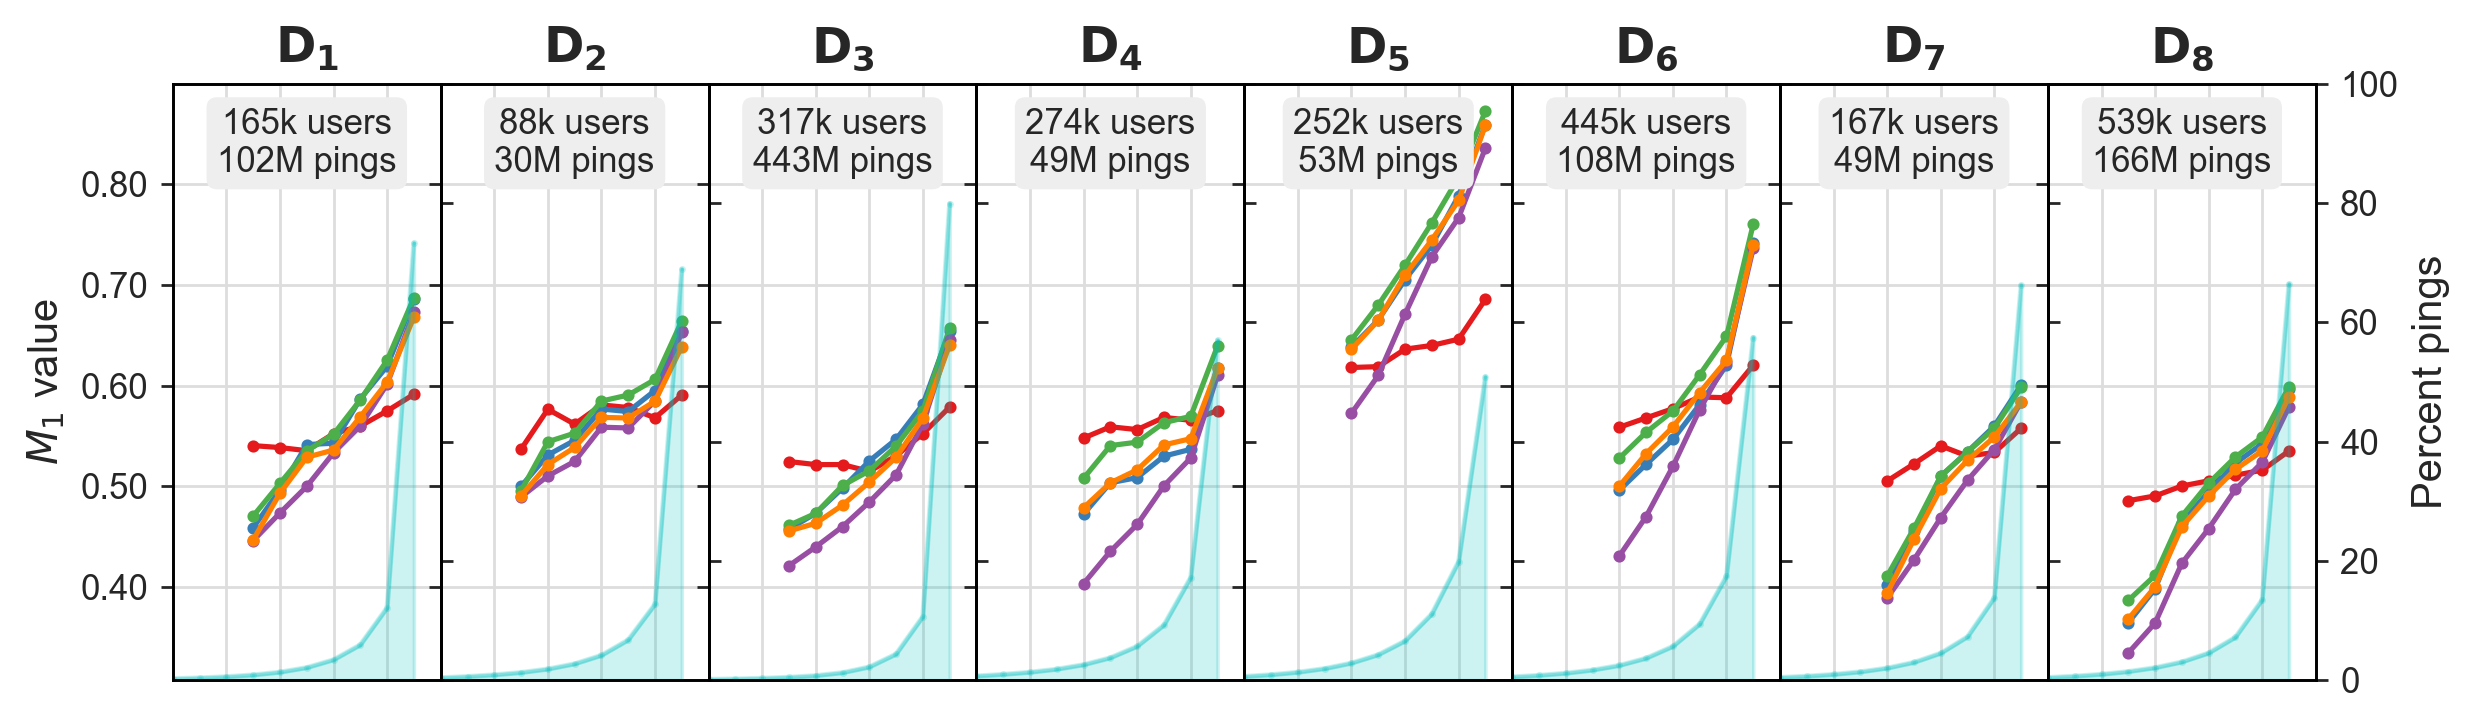

In [44]:
plot_m1_sensitivity(dpi=250)

## M2 curves

In [30]:
def get_m2_sensitivity(datasets=datasets, algos=algos, bins=10, hist_bins=100, 
                       max_dist=3.0, save=True, overwrite=False):
    pbar = tqdm(total=len(datasets) * len(algos))
    def dist4home(x, y, homex, homey):
        d = np.min(((Arr(x) - homex)**2 + (Arr(y) - homey)**2)**0.5)
        return dist_deg2m(d, homey)
    def median(x):
        return float(np.median(x))
    for i, ds in enumerate(datasets):
        idx = np.linspace(0, len(ds.counts), bins+1).astype(int)
        for j, alg in enumerate(algos):
            res = []
            pbar.update()
            pbar.set_description(f'{ds.key} -> {alg}')
            outfile = ds.data / f'sensitivity/{alg}/M2.parquet'
            if outfile.exists() and not overwrite:
                continue
            dists = pd.read_parquet(ds.data / f'metrics/{alg}/M2.parquet')
            for k in range(bins):
                xval = (k+1) * 100 / bins
                users = ds.counts.iloc[idx[k]: idx[k+1]]
                df = dists.merge(users, on=UID)
                df = df.groupby(UID).agg({'dist': np.median})['dist'] * U.M2MI
                if len(df) == 0: continue
                y, x = np.histogram(df.values.clip(0, max_dist), bins=hist_bins)
                y = y.cumsum() / y.sum() * 100
                yval = y.sum() / (100 * len(y))
                res.append(dict(binx=xval, m2=yval))
            res = Pdf(res).dropna()
            if save:
                res.to_parquet(U.mkfile(outfile))
    
%time x = get_m2_sensitivity(overwrite=False); x # t=1:02

  0%|          | 0/40 [00:00<?, ?it/s]

CPU times: user 40.7 ms, sys: 7.9 ms, total: 48.6 ms
Wall time: 35.8 ms


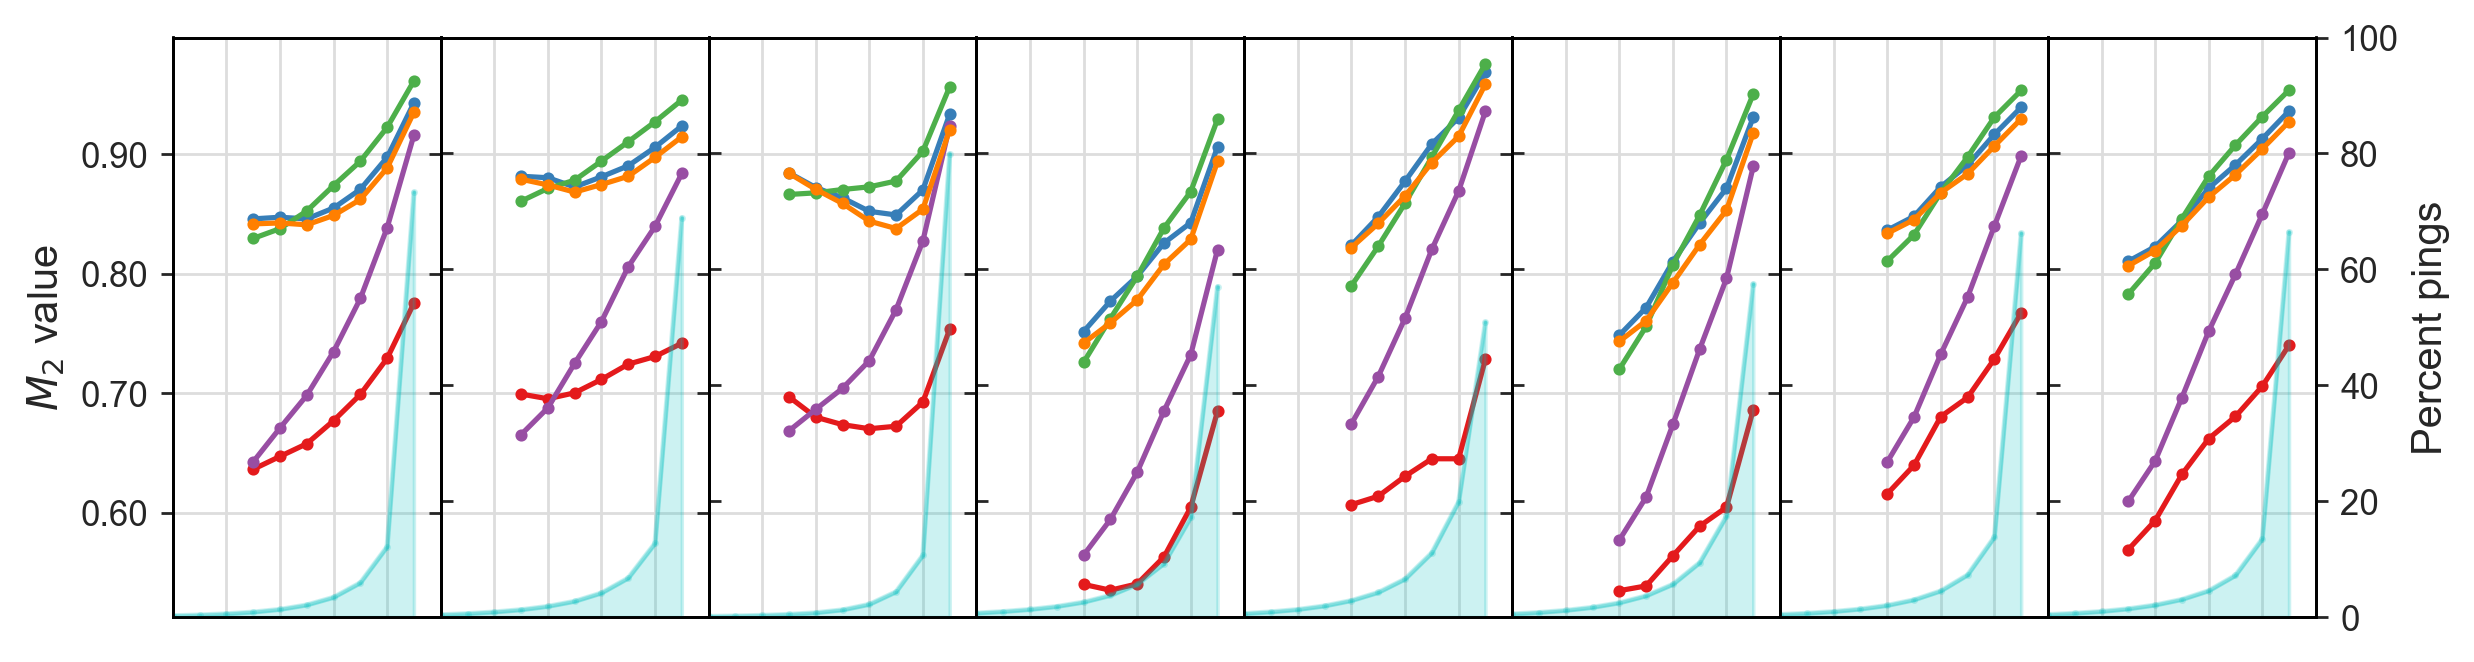

In [31]:
def plot_m2_sensitivity(datasets=datasets, algos=algos, colors=algo_colors,
                        ncol=8, panel_size=(1.25, 2.75), dpi=120):
    nrow = int(np.ceil(len(datasets) / ncol))
    figsize = (ncol * panel_size[0], nrow * panel_size[1])
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, 
                             dpi=dpi, sharey=True, sharex=True)
    axes = axes.flatten()
    for i, ds in enumerate(datasets):
        xlab = 'Percentile of users (best -> worst)' if i // ncol == nrow - 1 else ''
        ylab = r'$M_2$ value' if i % ncol == 0 else ''
        title = r'$\mathbf{%s_%s}$' % (ds.key[0], ds.key[1])
        title = None
        ax = U.plot(axes[i], framebordercolor='k', ylab=ylab, xlim=(0, 100), 
                    title=title, gridcolor='#ddd')
        for alg, color in zip(algos, algo_colors):
            df = pd.read_parquet(ds.data / f'sensitivity/{alg}/M2.parquet')
            label = '$%s_%s$' % (alg[0], alg[1])
            ax.plot(df['binx'], df['m2'], color=color, marker='.', 
                    label=label, markersize=5, lw=1.5)
        ax.invert_xaxis()
        ticks = np.arange(0, 100+1, 20)
        ax.set_xticks(ticks[:-1], ticks[::-1][:-1])
        ax.set_xticklabels([])
        ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}'))
        # if i == len(datasets) - 1: ax.legend(loc=(1.1, .4), ncol=1)
        twin = U.plot(ax.twinx(), ylim=(0, 100), framebordercolor='k')
        plot_quantile_ping_count(ds, twin, yticks=i == ncol - 1)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0)
    
plot_m2_sensitivity(dpi=250)

## M3 curves

In [32]:
def get_m3_sensitivity(datasets=datasets, algos=algos, bins=10, 
                       hist_bins=100, save=True, overwrite=False):
    pbar = tqdm(total=len(datasets) * len(algos))
    for ds in datasets:
        idx = np.linspace(0, len(ds.counts), bins+1).astype(int)
        for alg in algos:
            pbar.update()
            pbar.set_description(f'{ds.key} -> {alg}')
            outfile = ds.data / f'sensitivity/{alg}/M3.parquet'
            if outfile.exists() and not overwrite:
                continue
            res = []
            df_all = (pd.read_parquet(ds.data / f'metrics/{alg}/M3.parquet')
                      .merge(ds.counts, on=UID))
            for k in range(bins):
                xval = (k+1) * 100 / bins
                users = ds.counts.iloc[idx[k]: idx[k+1]]
                df = df_all.merge(users, on=UID)
                df['home_stay_ratio'] = 1 - df['home_time_spent'] / df['total_time_spent']
                if len(df) == 0: 
                    continue
                y, x = np.histogram(df['home_stay_ratio'], bins=bins); x = x[:-1]
                y = y.cumsum() / y.sum()
                res.append(dict(binx=xval, m3=y.mean()))
            res = Pdf(res).dropna()
            if save:
                res.to_parquet(U.mkfile(outfile))
    
x = get_m3_sensitivity(overwrite=True); x # t=0:21

  0%|          | 0/40 [00:00<?, ?it/s]

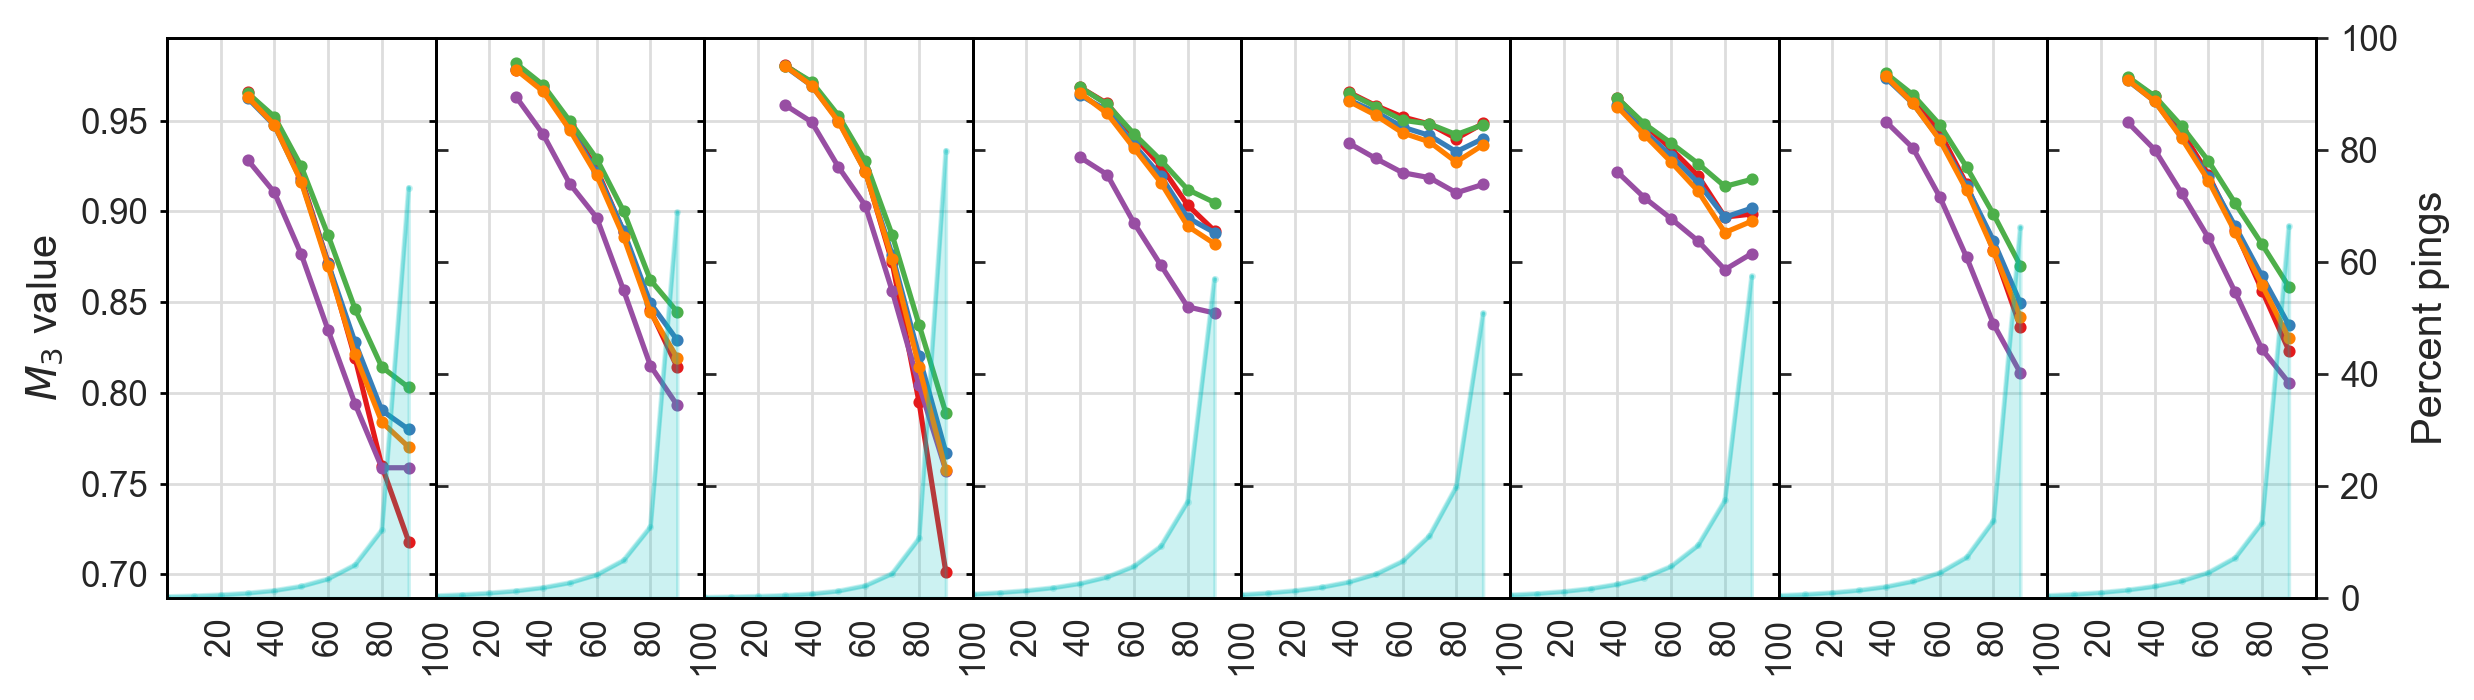

In [33]:
def plot_m3_sensitivity(datasets=datasets, algos=algos, colors=algo_colors,
                        ncol=8, panel_size=(1.25, 2.9), dpi=120):
    nrow = int(np.ceil(len(datasets) / ncol))
    figsize = (ncol * panel_size[0], nrow * panel_size[1])
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, 
                             dpi=dpi, sharey=True, sharex=True)
    axes = axes.flatten()
    for i, ds in enumerate(datasets):
        xlab = 'Percentile of users (best -> worst)' if i // ncol == nrow - 1 else ''
        ylab = r'$M_3$ value' if i % ncol == 0 else ''
        title = r'$\mathbf{%s_%s}$' % (ds.key[0], ds.key[1])
        title = None
        ax = U.plot(axes[i], framebordercolor='k', ylab=ylab, xlim=(0, 100), 
                    title=title, gridcolor='#ddd')
        for alg, color in zip(algos, colors):
            df = pd.read_parquet(ds.data / f'sensitivity/{alg}/M3.parquet')
            label = '$%s_%s$' % (alg[0], alg[1])
            ax.plot(df['binx'], df['m3'], color=color, marker='.', 
                    label=label, markersize=5, lw=1.5)
        ax.invert_xaxis()
        # if i == len(datasets) - 1: ax.legend(loc=(1.1, .4), ncol=1)
        twin = U.plot(ax.twinx(), ylim=(0, 100), framebordercolor='k')
        plot_quantile_ping_count(ds, twin, yticks=i == ncol - 1)
        ticks = np.arange(0, 100+1, 20)
        ax.set_xticks(ticks[:-1], ticks[::-1][:-1], rotation=90)
        ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}'))
        ax.tick_params(axis='both', which='major', length=2, color='k')
    plt.setp([ax.get_xticklabels() for ax in axes], visible=True)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0)
    
plot_m3_sensitivity(dpi=250)

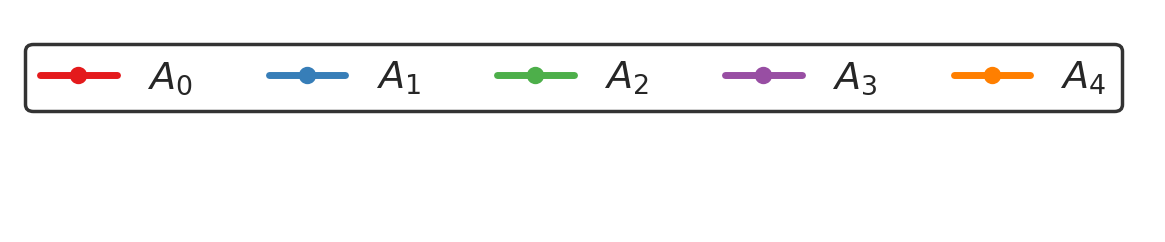

In [34]:
ax = U.plot(size=(1, 1), dpi=250)
ax.legend(handles=[
    mpl.lines.Line2D([0], [0], marker='.', markersize=8, color=color,
                     lw=2, label='$%s_%s$' % (alg[0], alg[1])) 
    for alg, color in zip(algos, algo_colors)], 
          ncol=len(algos), edgecolor='k')
ax.axis('off');